### 📊 Análisis de Sentimientos en Redes Sociales y Plataformas de E-commerce

En este cuaderno realizamos un análisis de sentimientos a partir de un dataset real llamado **`sentiment_dataset.csv`**.  
El objetivo es identificar tendencias de percepción (positiva, negativa y neutral) en opiniones de usuarios, considerando tanto texto como emojis/emoticones.  

Para este análisis utilizamos un enfoque basado en un **lexicón en español**, el cual asigna puntajes positivos o negativos a palabras clave y emojis.  
Con ello, podemos calcular un **sentiment score** para cada registro y luego generar **etiquetas de polaridad** (positivo, neutral, negativo).  

Finalmente, se construyen indicadores clave de negocio (KPIs) y se generan diferentes visualizaciones que permiten comprender el comportamiento del sentimiento en distintas plataformas, marcas y calificaciones de producto.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from collections import defaultdict

df = pd.read_csv("../data/sentiment_dataset.csv")

if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
else:
    df["timestamp"] = pd.date_range(start="2023-01-01", periods=len(df), freq="D")

df["date"] = df["timestamp"].dt.date
df["week"] = df["timestamp"].dt.to_period("W").apply(lambda r: r.start_time.date())

if "is_social" not in df.columns and "platform" in df.columns:
    social_platforms = ["X/Twitter", "Instagram", "Reddit", "TikTok"]
    df["is_social"] = df["platform"].isin(social_platforms)
elif "is_social" not in df.columns:
    df["is_social"] = False  # fallback

## Lexicón de sentimientos

El análisis se basa en un **lexicón en español** que asigna un puntaje a palabras y emojis comunes en reseñas.  

- Palabras positivas como *"excelente", "perfecto", "increíble"* reciben valores altos y positivos.  
- Palabras negativas como *"horrible", "mala", "falló"* reciben valores negativos.  
- Emojis también son considerados, por ejemplo 👍 y 😍 como positivos, 👎 y 😞 como negativos.  
- Se incluyen intensificadores (*"muy", "súper"*) y negadores (*"no", "nunca"*) que modifican el puntaje final.  

Esto permite captar mejor la polaridad de las opiniones escritas en un lenguaje informal, mezclado con emoticones y hashtags.


In [8]:
# -------------------------------
#    Lexicón de sentimientos
# -------------------------------
lexicon = {
    # positivo
    "excelente": 2.5, "recomendado": 1.8, "maravilla": 2.0, "rápida": 1.2, "rapida": 1.2,
    "rápido": 1.2, "rapido": 1.2, "buena": 1.2, "impresionante": 2.0, "amable": 1.3,
    "elegante": 1.0, "sólido": 1.0, "solido": 1.0, "genial": 2.0, "útil": 1.3, "util": 1.3,
    "encantó": 2.0, "encanto": 2.0, "vale": 1.0, "recomiendo": 1.8, "recomendable": 1.8,
    "funciona": 1.2, "satisfecho": 1.6, "perfecto": 2.2, "increíble": 2.3, "increible": 2.3,
    "bien": 0.8,
    # negativo
    "mala": -1.6, "pésima": -2.5, "pesima": -2.5, "decepcionante": -2.2, "lenta": -1.0,
    "lento": -1.0, "caro": -1.1, "cara": -1.1, "terrible": -2.4, "defectuoso": -2.0,
    "rompió": -2.3, "rompio": -2.3, "horrible": -2.6, "arrepiento": -2.0, "no": -0.4,
    "nunca": -0.6, "peor": -2.4, "falló": -2.0, "fallo": -2.0,
    # neutro-ish
    "normal": 0.0, "básico": 0.0, "basico": 0.0, "describe": 0.0, "veremos": 0.0,
    # emojis positivos
    "👍": 1.5, "✨": 1.2, "🔥": 1.3, "💯": 2.0, "😍": 2.3,
    # emojis negativos
    "👎": -1.5, "💔": -2.0, "😠": -1.8, "😤": -1.7, "😞": -1.6,
    # emojis neutrales
    "🤔": 0.0, "😐": 0.0
}
intensifiers = {"muy": 1.4, "súper": 1.6, "super": 1.6, "demasiado": 1.5, "bastante": 1.2}
negators = {"no", "nunca", "jamás", "jamas"}

## Procesamiento de texto y cálculo de sentimiento

Para analizar los comentarios, se realiza un proceso de **tokenización**, es decir, dividir el texto en palabras y símbolos relevantes.  

La función de tokenización mantiene letras, acentos, hashtags y emojis básicos, eliminando caracteres innecesarios.  

Luego, se aplica la función `score_sentiment`:
- Recorre los tokens del texto.  
- Suma los puntajes según el lexicón.  
- Aplica reglas de intensificación y negación.  
- Normaliza el resultado por la longitud del texto para evitar que reseñas largas dominen sobre las cortas.  

Finalmente, cada registro recibe un **sentiment score** numérico y una etiqueta categórica:
- **Positivo**: score ≥ 0.6  
- **Negativo**: score ≤ -0.6  
- **Neutral**: valores intermedios


In [9]:
# -------------------------------
# 3) Procesamiento de texto
# -------------------------------
def tokenize(text):
    if not isinstance(text, str):
        return []
    txt = text.lower()
    # Mantener letras, acentos, hashtags y emojis básicos
    allowed = string.ascii_letters + "áéíóúñü#👍✨🔥💯😍👎💔😠😤😞🤔😐 "  
    cleaned = "".join(ch if ch.lower() in allowed else " " for ch in txt)
    tokens = [t for t in cleaned.split() if t]
    return tokens

def score_sentiment(text):
    tokens = tokenize(text)
    total = 0.0
    i = 0
    negate_window = 0
    while i < len(tokens):
        t = tokens[i]
        val = 0.0
        if t in intensifiers:
            if i+1 < len(tokens):
                next_t = tokens[i+1]
                base = lexicon.get(next_t, 0.0)
                val += base * intensifiers[t]
                i += 1
        elif t in lexicon:
            val += lexicon[t]
        if t in negators:
            negate_window = 3
        if negate_window > 0 and val != 0.0:
            val = -val
        total += val
        if negate_window > 0:
            negate_window -= 1
        i += 1
    norm = len(tokens)**0.5 if len(tokens) > 0 else 1.0
    return total / norm

df["sentiment_score"] = df["text"].apply(score_sentiment)

def label_score(s):
    if s >= 0.6:
        return "positivo"
    elif s <= -0.6:
        return "negativo"
    else:
        return "neutral"

df["sentiment_label"] = df["sentiment_score"].apply(label_score)

## Indicadores clave (KPIs)

Se construyen indicadores que permiten medir el panorama general del dataset:  

- **Total de registros** analizados.  
- **Porcentaje de opiniones positivas, negativas y neutrales**.  
- **Promedio de rating** en plataformas de e-commerce (cuando existe).  
- **Mediana de likes** en redes sociales (cuando existe).  

Estos KPIs proporcionan una visión ejecutiva del estado de la percepción del público hacia las marcas y productos.


In [10]:
# -------------------------------
# 4) KPIs
# -------------------------------
kpis = {
    "Total registros": len(df),
    "Porcentaje positivo": round((df["sentiment_label"]=="positivo").mean()*100, 1),
    "Porcentaje neutral": round((df["sentiment_label"]=="neutral").mean()*100, 1),
    "Porcentaje negativo": round((df["sentiment_label"]=="negativo").mean()*100, 1),
    "Promedio rating (solo e-commerce)": round(df.loc[~df["is_social"], "rating"].mean(), 2) if "rating" in df.columns else None,
    "Mediana likes (solo social)": int(df.loc[df["is_social"], "likes"].median()) if "likes" in df.columns else None
}
print(kpis)

{'Total registros': 1200, 'Porcentaje positivo': np.float64(42.9), 'Porcentaje neutral': np.float64(42.3), 'Porcentaje negativo': np.float64(14.8), 'Promedio rating (solo e-commerce)': np.float64(3.81), 'Mediana likes (solo social)': 23}


## Agregaciones y análisis previo a visualizaciones

Antes de generar las gráficas, se preparan distintas agregaciones:  

- **Distribución de sentimiento por plataforma**: compara polaridades en cada red social o e-commerce.  
- **Promedio de sentimiento por marca**: muestra qué marcas son mejor percibidas en general.  
- **Serie temporal por semana**: permite observar la evolución del sentimiento a lo largo del tiempo.  
- **Relación entre rating y sentimiento**: evalúa si las reseñas con calificaciones más altas corresponden a un mayor puntaje en el análisis de texto.  
- **Tokens más frecuentes y su contribución**: identifica las palabras o emojis que más influyen positiva o negativamente en el resultado.  

Con estas transformaciones, se cuenta con una base sólida para las visualizaciones que permitirán comunicar hallazgos de forma más clara.


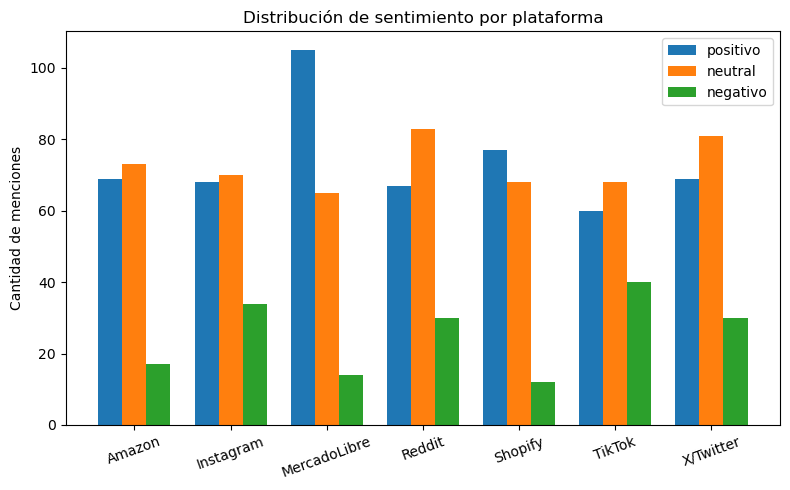

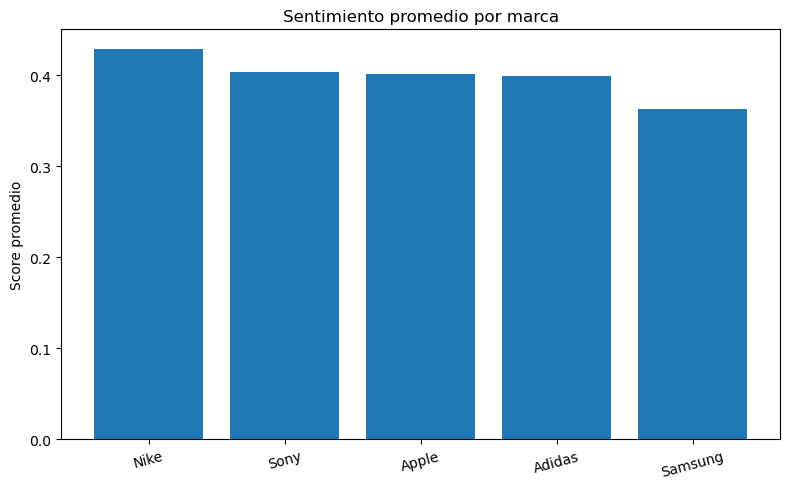

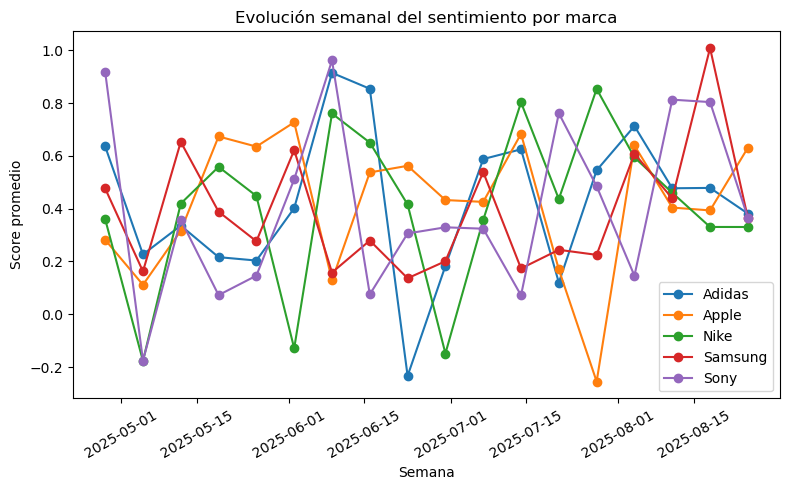

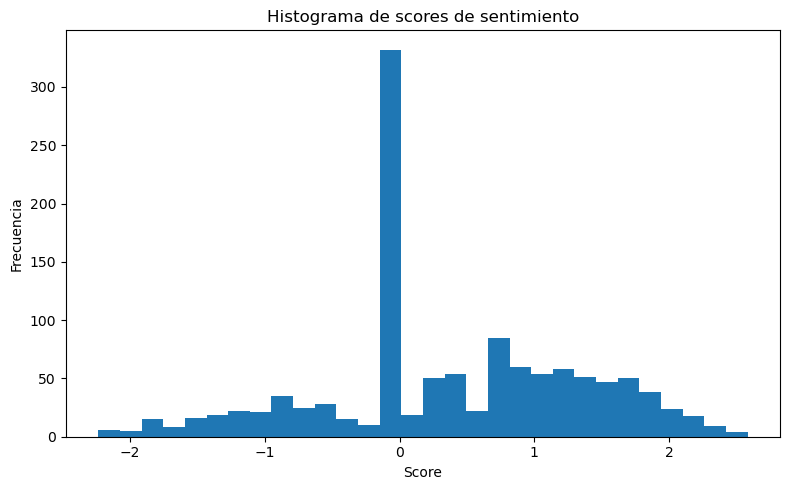

C:\Users\EmilB\AppData\Local\Temp\ipykernel_12048\2577041990.py:80: UserWarning: Glyph 128175 (\N{HUNDRED POINTS SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\EmilB\AppData\Local\Temp\ipykernel_12048\2577041990.py:80: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\EmilB\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128175 (\N{HUNDRED POINTS SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\EmilB\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


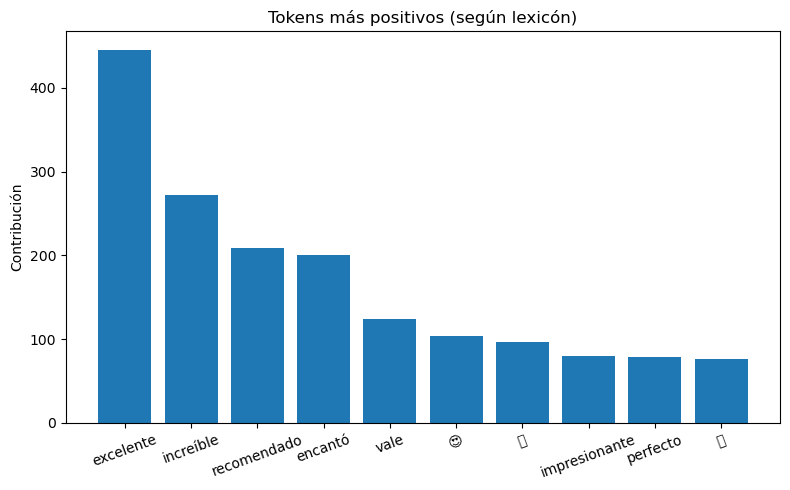

C:\Users\EmilB\AppData\Local\Temp\ipykernel_12048\2577041990.py:88: UserWarning: Glyph 128148 (\N{BROKEN HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\EmilB\AppData\Local\Temp\ipykernel_12048\2577041990.py:88: UserWarning: Glyph 128548 (\N{FACE WITH LOOK OF TRIUMPH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\EmilB\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128148 (\N{BROKEN HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\EmilB\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128548 (\N{FACE WITH LOOK OF TRIUMPH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


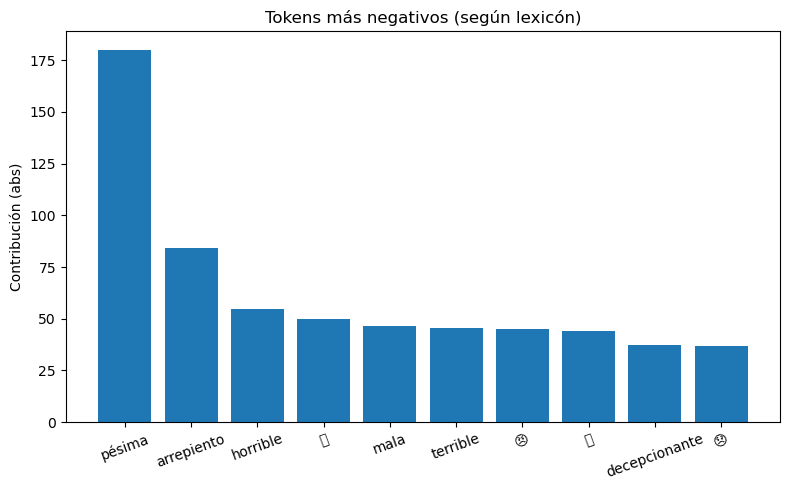

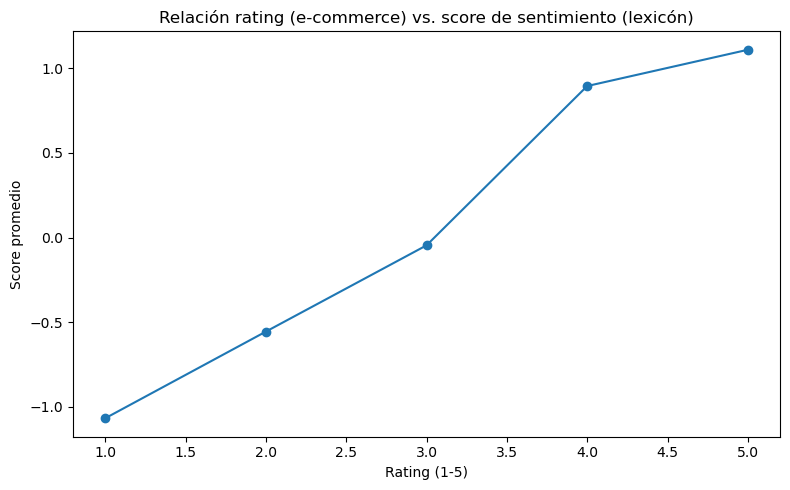

In [11]:
# -------------------------------
# 5) Visualizaciones
# -------------------------------

# Distribución de sentimiento por plataforma
if "platform" in df.columns:
    sent_by_platform = df.groupby(["platform", "sentiment_label"]).size().unstack(fill_value=0)

    plt.figure(figsize=(8,5))
    for i, label in enumerate(["positivo", "neutral", "negativo"]):
        y = sent_by_platform[label].values if label in sent_by_platform else np.zeros(len(sent_by_platform))
        x = np.arange(len(sent_by_platform.index)) + i*0.25
        plt.bar(x, y, width=0.25, label=label)
    plt.xticks(np.arange(len(sent_by_platform.index)) + 0.25, sent_by_platform.index, rotation=20)
    plt.ylabel("Cantidad de menciones")
    plt.title("Distribución de sentimiento por plataforma")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Sentimiento promedio por marca
if "brand" in df.columns:
    avg_score_by_brand = df.groupby("brand")["sentiment_score"].mean().sort_values(ascending=False)

    plt.figure(figsize=(8,5))
    plt.bar(avg_score_by_brand.index, avg_score_by_brand.values)
    plt.ylabel("Score promedio")
    plt.title("Sentimiento promedio por marca")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

# Evolución semanal del sentimiento por marca
if "brand" in df.columns:
    time_series = df.groupby(["week", "brand"])["sentiment_score"].mean().reset_index()

    plt.figure(figsize=(8,5))
    for b in time_series["brand"].unique():
        series = time_series[time_series["brand"]==b]
        plt.plot(series["week"], series["sentiment_score"], marker="o", label=b)
    plt.title("Evolución semanal del sentimiento por marca")
    plt.xlabel("Semana")
    plt.ylabel("Score promedio")
    plt.xticks(rotation=30)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Histograma de scores
plt.figure(figsize=(8,5))
plt.hist(df["sentiment_score"], bins=30)
plt.title("Histograma de scores de sentimiento")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# Tokens más positivos y negativos
def token_scores(df_subset):
    totals = defaultdict(float)
    counts = defaultdict(int)
    for text in df_subset["text"]:
        for tok in tokenize(text):
            if tok in lexicon:
                totals[tok] += lexicon[tok]
                counts[tok] += 1
    items = [(tok, counts[tok], totals[tok]) for tok in totals]
    res = pd.DataFrame(items, columns=["token", "count", "lexicon_contribution"]).sort_values("count", ascending=False)
    return res

tokens_overall = token_scores(df)
top_pos_tokens = tokens_overall.sort_values("lexicon_contribution", ascending=False).head(10)
top_neg_tokens = tokens_overall.sort_values("lexicon_contribution").head(10)

plt.figure(figsize=(8,5))
plt.bar(top_pos_tokens["token"], top_pos_tokens["lexicon_contribution"])
plt.title("Tokens más positivos (según lexicón)")
plt.xticks(rotation=20)
plt.ylabel("Contribución")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.bar(top_neg_tokens["token"], -top_neg_tokens["lexicon_contribution"])
plt.title("Tokens más negativos (según lexicón)")
plt.xticks(rotation=20)
plt.ylabel("Contribución (abs)")
plt.tight_layout()
plt.show()

# Relación rating vs sentimiento
if "rating" in df.columns and not df["rating"].isna().all():
    rating_vs_sent = df.loc[~df["is_social"]].groupby("rating")["sentiment_score"].mean().reset_index()

    plt.figure(figsize=(8,5))
    plt.plot(rating_vs_sent["rating"], rating_vs_sent["sentiment_score"], marker="o")
    plt.title("Relación rating (e-commerce) vs. score de sentimiento (lexicón)")
    plt.xlabel("Rating (1-5)")
    plt.ylabel("Score promedio")
    plt.tight_layout()
    plt.show()